# Notebook for downscaling paper figure : model-scenario scatterplot of trends in global average precipitation and temperature, GDPCIR datasets versus source datasets. 

last updated : 2022/12/14, by Emile Tenezakis (e.tenezakis@gmail.com).
scaling : none, everything is running locally and very fast with small datasets stored in the public downscaling CMIP6 buckets.   
output : notebook saves the figure to user specific `savefig_path` defined below. 
library dependencies : nothing particular to flag.   
data dependencies : publicly available GDPCIR diagnostic datasets stored on google cloud.

In [130]:
import xarray as xr
import pandas as pd
import numpy as np
import gcsfs
import itertools

import matplotlib.pyplot as plt
import cartopy.crs as ccrs

%matplotlib inline

Local, hard coded path.

In [131]:
savefig_path = '/home/jovyan/tests'

publicly available diagnostic datasets URLs

In [132]:
fps = {'precip_clean':'gs://downscaled-288ec5ac/diagnostics/paper_figures/global_means_gdpcir_versus_source/precip_clean.zarr',
       'precip_gdpcir':'gs://downscaled-288ec5ac/diagnostics/paper_figures/global_means_gdpcir_versus_source/precip_gdpcir.zarr',
       'tasmax_clean':'gs://downscaled-288ec5ac/diagnostics/paper_figures/global_means_gdpcir_versus_source/tasmax_clean.zarr',
       'tasmax_gdpcir':'gs://downscaled-288ec5ac/diagnostics/paper_figures/global_means_gdpcir_versus_source/tasmax_gdpcir.zarr'
      }

contains the list of models to plot.

In [133]:
MODELS_BY_LICENSE = {
    "cc0": [
        "FGOALS-g3",
        "INM-CM4-8",
        "INM-CM5-0",
    ],
    "cc_by": [
        "ACCESS-CM2",
        "ACCESS-ESM1-5",
        "BCC-CSM2-MR",
        "CMCC-CM2-SR5",
        "CMCC-ESM2",
        "EC-Earth3-AerChem",
        "EC-Earth3-CC",
        "EC-Earth3-Veg-LR",
        "EC-Earth3-Veg",
        "EC-Earth3",
        "GFDL-CM4",
        "GFDL-ESM4",
        "HadGEM3-GC31-LL",
        "MIROC-ES2L",
        "MIROC6",
        "MPI-ESM1-2-HR",
        "MPI-ESM1-2-LR",
        "NESM3",
        "NorESM2-LM",
        "NorESM2-MM",
        "UKESM1-0-LL",
    ],
    "cc_by_sa": [
        "CanESM5",
    ]
}

ALL_MODELS = sum(MODELS_BY_LICENSE.values(), [])

small datasets -- can load everything.

In [134]:
precip_clean = xr.open_zarr(fps['precip_clean']).da.load()
precip_gdpcir = xr.open_zarr(fps['precip_gdpcir']).da.load()
tasmax_clean = xr.open_zarr(fps['tasmax_clean']).da.load() 
tasmax_gdpcir = xr.open_zarr(fps['tasmax_gdpcir']).da.load()

Values for the paper text

In [156]:
for dt in ['tasmax','precip']:
    print(f'-- variable {dt} --')
    if dt == 'tasmax':
        dtset_clean = tasmax_clean.copy(deep=True)
        dtset_gdpcir = tasmax_gdpcir.copy(deep=True)
        func = lambda x: x
    else:
        dtset_clean = precip_clean.copy(deep=True)
        dtset_gdpcir = precip_gdpcir.copy(deep=True)
        func = lambda x: (x-1)*100
        
    for scen in ['ssp245', 'ssp370']:

        print(f'-- min/max changes in source data {dt} {scen} -- \n')

        print(func(dtset_clean.sel(scenario=scen).min().values.item()), dtset_clean.model[dtset_clean.sel(scenario=scen).argmin()].values.item())
        print(func(dtset_clean.sel(scenario=scen).max().values.item()), dtset_clean.model[dtset_clean.sel(scenario=scen).argmax()].values.item())


        print(f'\n -- min/max changes in GDPCIR data {dt} {scen} -- \n')


        print(func(dtset_gdpcir.sel(scenario=scen).min().values.item()), dtset_gdpcir.model[dtset_gdpcir.sel(scenario=scen).argmin()].values.item())
        print(func(dtset_gdpcir.sel(scenario=scen).max().values.item()), dtset_gdpcir.model[dtset_gdpcir.sel(scenario=scen).argmax()].values.item())
        
        print('\n')
    
    print('\n \n')


-- variable tasmax --
-- min/max changes in source data tasmax ssp245 -- 

1.713348388671875 INM-CM4-8
4.550567626953125 UKESM1-0-LL

 -- min/max changes in GDPCIR data tasmax ssp245 -- 

1.705902099609375 INM-CM4-8
4.5498046875 UKESM1-0-LL


-- min/max changes in source data tasmax ssp370 -- 

2.560394287109375 CAMS-CSM1-0
6.53436279296875 UKESM1-0-LL

 -- min/max changes in GDPCIR data tasmax ssp370 -- 

2.83935546875 INM-CM4-8
6.537384033203125 UKESM1-0-LL



 

-- variable precip --
-- min/max changes in source data precip ssp245 -- 

-0.11473298072814941 NorESM2-MM
8.989441394805908 CMCC-CM2-SR5

 -- min/max changes in GDPCIR data precip ssp245 -- 

2.571544604300824 BCC-CSM2-MR
12.593616507976591 CanESM5


-- min/max changes in source data precip ssp370 -- 

-2.465718984603882 GFDL-ESM4
9.607017040252686 EC-Earth3

 -- min/max changes in GDPCIR data precip ssp370 -- 

-0.7940727586011942 GFDL-ESM4
15.216365609316274 CanESM5



 



In [141]:
tasmax_clean.model[tasmax_clean.sel(scenario='ssp245').argmin()]

<xarray.DataArray 'model' ()>
array('INM-CM4-8', dtype='<U16')
Coordinates:
    model     <U16 'INM-CM4-8'
    scenario  <U6 'ssp245'

markers in the scatterplot for each model. Each model gets its own provided model index does not change.

In [125]:
markerlst = ["p", "d", "o", "*", "s", "v", ">", "P", "<", "8", "^", "H", "D", "X"]
colorlst = [
    "#a6cee3",
    "#1f78b4",
    "#b2df8a",
    "#33a02c",
    "#fb9a99",
    "#e31a1c",
    "#fdbf6f",
    "#ff7f00",
    "#cab2d6",
]


pspec = {}
for mii, mm in enumerate(ALL_MODELS):
    # assign marker and color
    pspec[mm] = (markerlst[mii % len(markerlst)], colorlst[mii % len(colorlst)])

because the set of models in the datasets are not necessarily the same as the above.

In [126]:
PLOT_MODELS = tasmax_gdpcir.model.values

this makes the figure. We have one chunk of code for each scenario. For each scenario, we loop over all models and add the given X-Y datapoint to the initialized plot.

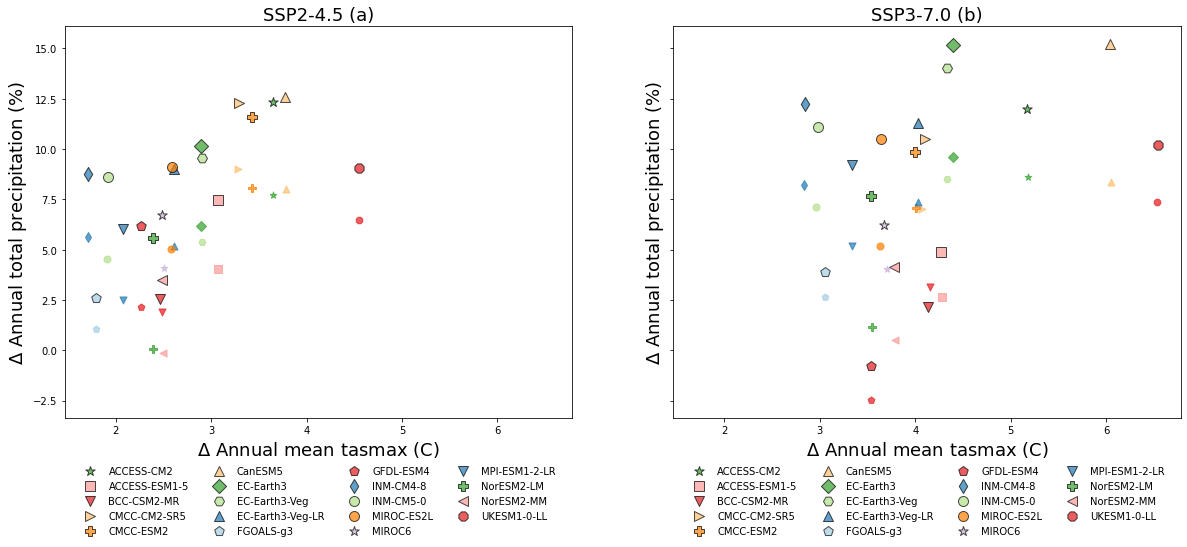

In [129]:
fig, axs = plt.subplots(1, 2, figsize=(20, 8), sharex=True, sharey=True)

scen = "ssp245"
tplt = tasmax_gdpcir.copy(deep=True)
pplt = (precip_gdpcir.copy(deep=True)-1)*100
cltgm = tasmax_clean.copy(deep=True)
clpgm = (precip_clean.copy(deep=True)-1)*100
markers = itertools.cycle(markerlst) 
colors = itertools.cycle(colorlst) 
models45 = PLOT_MODELS
models4570 = PLOT_MODELS

ax = axs[0]

for mm in models45:

    plotx =  tplt.sel(model=mm, scenario=scen)
    ploty = pplt.sel(model=mm,scenario=scen)

    ax.scatter(plotx, ploty, s=100, marker=pspec[mm][0], color=pspec[mm][1],alpha=.7,
               edgecolors="k")  

# ===
# Shrink current axis's height by 10% on the bottom
box = ax.get_position()
ax.set_position([box.x0, box.y0 + box.height * 0.1,
                 box.width, box.height * 0.9])

# Put a legend below current axis
ax.legend((models45),loc='upper center', bbox_to_anchor=(0.5, -0.1),
          frameon=False,fancybox=True, shadow=True, ncol=4)
# ===
for mm in models45:
    
    plotclx = cltgm.sel(model=mm, scenario=scen)
    plotcly = clpgm.sel(model=mm, scenario=scen)
    
    ax.scatter(plotclx, 
               plotcly, s=50, marker=pspec[mm][0], color=pspec[mm][1],alpha=.7)  


ax.set_xlabel("$\Delta$ Annual mean tasmax (C)", fontsize=18)
ax.set_ylabel("$\Delta$ Annual total precipitation (%)", fontsize=18)
ax.set_title(f"SSP2-4.5 (a)", fontsize=18) # {ttl} \n2080-2099 change relative 1995-2014


scen = "ssp370"

markers = itertools.cycle(markerlst) 
colors = itertools.cycle(colorlst) 

ax = axs[1]

for mm in models4570:

    plotx = tplt.sel(scenario=scen, model=mm)
    ploty = pplt.sel(model=mm,scenario=scen)
    
    ax.scatter(plotx, ploty, s=100, marker=pspec[mm][0], color=pspec[mm][1],alpha=.7,
               edgecolors="k")  

# ===
# Shrink current axis's height by 10% on the bottom
box = ax.get_position()
ax.set_position([box.x0, box.y0 + box.height * 0.1,
                 box.width, box.height * 0.9])

# Put a legend below current axis
ax.legend((models4570),loc='upper center', bbox_to_anchor=(0.5, -0.1),
          frameon=False,fancybox=True, shadow=True, ncol=4)
# ===
for mm in models4570:
    
    plotclx = cltgm.sel(scenario=scen, model=mm)
    plotcly = clpgm.sel(scenario=scen, model=mm)
    
    ax.scatter(plotclx, 
               plotcly, s=50, marker=pspec[mm][0], color=pspec[mm][1],alpha=.7)  


ax.set_xlabel("$\Delta$ Annual mean tasmax (C)", fontsize=18)
ax.set_ylabel("$\Delta$ Annual total precipitation (%)", fontsize=18)
ax.set_title(f"SSP3-7.0 (b)", fontsize=18) # {ttl} \n2080-2099 change relative 1995-2014


fig.savefig(f"{savefig_path}/scatterplot_trends_global_average_source_versus_gdpcir.png",dpi=300, bbox_inches="tight", facecolor='white')